In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.colors as plcol
from scipy import integrate
import matplotlib as mpl

In [24]:
def read_prop_with_freq1(prop_name, dens, N_part, alph, alph_or_lambd, freqout):
    filename = f"{prop_name}_density_{dens:.2f}_Npart_{N_part}_{alph_or_lambd}_{alph:.1f}_Freqout_{freqout}.txt"
    prop_val = np.loadtxt(filename)  
    return prop_val[:, 0], prop_val[:, 1]

In [25]:
def read_prop_with_freq2(prop_name, dens, N_part, alph, alph_or_lambd, freqout):
    filename = f"{prop_name}2_density_{dens:.2f}_Npart_{N_part}_{alph_or_lambd}_{alph:.1f}_Freqout_{freqout}.txt"
    prop_val = np.loadtxt(filename)  
    return prop_val[:, 0], prop_val[:, 1]

In [26]:
def linear_func(x, b):
    return x + b

In [27]:
def linear_func2(x, a, b):
    return a * x + b

In [28]:
def fit_D(D, Derr, T): 
    lg_D = np.log10(D)
    lg_T = np.log10(T)
    lg_Derr = np.log(10) * Derr / D
    
    popt, pcov = curve_fit(linear_func2, lg_T, lg_D, sigma=lg_Derr)
    perr = np.sqrt(np.diag(pcov))
    appr = (10**(popt[1])) * T**popt[0]
    
    alph_err = perr[0] # where D = A * T^alph
    A_err = 10**popt[1] * np.log(10) * perr[1]
    appr_err = appr * np.sqrt((A_err / popt[1])**2 + (np.log(T) * alph_err)**2)
    return popt[0], alph_err, appr, appr_err

In [29]:
def fit_MSD(msd, t):
    C1, pcov = curve_fit(linear_func, np.log10(t), np.log10(msd))  # lg(msd) = lg(6D) + lg(t) = C1 + lg(t)
    D = (10**C1) / 6 # diffusion coefficient
    perr = np.sqrt(np.diag(pcov)) 
    D_err = D * np.log(10) * perr
    return D, D_err

In [ ]:
def MSD_plot1(dens, lambd):
    MSD = np.zeros((np.size(lambd), Nsave))
    D = np.zeros(np.size(lambd)) # diffusion coefficient
    Derr = np.zeros(np.size(lambd))
    print('\nFor density = {0}'.format(dens))
    plt.figure(figsize=(5, 4))
    for i in range (np.size(lambd)):
        time, MSD[i, :] = read_prop_with_freq1('MSD', dens, 512, lambd[i], 'lambda', 1000)    
        D[i], Derr[i]  = fit_MSD(MSD[i, 100:], time[100:])
            
        plt.plot(time, MSD[i, :], label=r'$T_\sigma$ = {0}'.format(lambd[i]), linewidth=2, color=colors[i, :])
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(0, 1000)
    plt.ylim(0, 10000)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(r'$t$ / $\tau_{BD}$', fontsize=15)
    plt.ylabel('$< \Delta r^2>$ / $\sigma_0 ^2$', fontsize=15)
    plt.legend(ncol=2, fontsize=11.3)
    plt.show()
    return D, Derr

In [ ]:
def MSD_plot2(dens, lambd):
    MSD = np.zeros((np.size(lambd), Nsave))
    D = np.zeros(np.size(lambd)) # diffusion coefficient
    Derr = np.zeros(np.size(lambd))
    print('\nFor density = {0}'.format(dens))
    plt.figure(figsize=(5, 4))
    for i in range (np.size(lambd)):
        time, MSD[i, :] = read_prop_with_freq2('MSD', dens, 512, lambd[i], 'lambda', 1000)    
        D[i], Derr[i]  = fit_MSD(MSD[i, 100:], time[100:])
            
        plt.plot(time, MSD[i, :], label=r'$T_\sigma$ = {0}'.format(lambd[i]), linewidth=2, color=colors[i, :])
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(0, 1000)
    plt.ylim(0, 10000)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(r'$t$ / $\tau_{BD}$', fontsize=15)
    plt.ylabel('$< \Delta r^2>$ / $\sigma_0 ^2$', fontsize=15)
    plt.legend(ncol=2, fontsize=11.3)
    plt.show()
    return D, Derr

In [ ]:
def N_sigma_analysis2(dens, sim, lambd):
    N = np.zeros((np.size(lambd), 100))
    mean_prime = np.zeros(np.size(lambd))
    lambd_th = np.linspace(0.01, 30, 100)
    mean_D = np.zeros(np.size(lambd_th))
    if sim == 1:
        func = read_prop_with_freq1
    elif sim == 2:
        func = read_prop_with_freq2
    
    print('\nFor density = {0}'.format(dens))
    for i in range (np.size(lambd)):
        sigmaval, N[i, :] = func('N_sigma', dens, 512, lambd[i], 'lambda', 1000)
        delta_sigma = sigmaval[1] - sigmaval[0]
        N[i, :] = N[i, :] / delta_sigma
        
        mean_prime[i] = calc_mean_prime(sigmaval, N[i], lambd[i], sim) 
    for j in range (np.size(lambd_th)):
            mean_D[j] = calc_mean_D(sigmaval, lambd_th[j], sim)   
        
    return mean_prime, mean_D, lambd_th

In [33]:
def calc_mean_prime(sigma, N, T_sigma, sim):
    #for i in range (np.size(sigma)):
    #    integr_func = N[i] * sigma[i]
    #if sim == 1:
    #    func = init_prob
    #elif sim == 2:
    #    func = init_prob2
    #p_0 = func(sigma, T_sigma)
    mean_prime = integrate.trapz(N * sigma, sigma)
    return mean_prime

In [34]:
def calc_mean_D(sigma, T_sigma, sim):
    integr_func = np.zeros(np.size(sigma))
    if sim == 1:
        func = init_prob
    elif sim == 2:
        func = init_prob2
    p_0 = func(sigma, T_sigma)
    for i in range (np.size(sigma)):
        #integr_func[i] = N[i] / sigma[i]
        integr_func[i] = p_0[i] / sigma[i]
    mean_D = integrate.trapz(integr_func, sigma)
    return mean_D

In [35]:
def init_prob(sigma, T_sigma):
    Teff = T_sigma
    var = 0.04 * Teff / T_sigma
    sigma0 = 1.0
    p = np.exp(- (sigma - sigma0)**2 / (2 * var)) / np.sqrt(2 * np.pi * var)
    return p

In [36]:
def init_prob2(sigma, T_sigma):
    Teff = T0
    var = 0.04 * T_sigma / Teff
    sigma0 = 1.0
    p = np.exp(- (sigma - sigma0)**2 / (2 * var)) / np.sqrt(2 * np.pi * var)
    return p

In [ ]:
def mean_Ds_review(dens, sim, lambd):
    N = np.zeros((np.size(lambd), 100))
    mean_prime = np.zeros(np.size(lambd))
    #lambd_th = np.linspace(0.01, 30, 100)
    mean_D = np.zeros(np.size(lambd))
    mean_D2 = np.zeros(np.size(lambd))
    if sim == 1:
        func = read_prop_with_freq1
    elif sim == 2:
        func = read_prop_with_freq2
    
    print('\nFor density = {0}'.format(dens))
    for i in range (np.size(lambd)):
        sigmaval, N[i, :] = func('N_sigma', dens, 512, lambd[i], 'lambda', 1000)
        delta_sigma = sigmaval[1] - sigmaval[0]
        N[i, :] = N[i, :] / delta_sigma
        
        
        mean_prime[i] = calc_mean_prime_rev(sigmaval, N[i], lambd[i]) 
        mean_D2[i] = 1 / mean_prime[i]
        mean_D[i] = calc_mean_D_rev(sigmaval, N[i], lambd[i])   
        
    return mean_D, mean_D2, mean_prime

In [38]:
def calc_mean_prime_rev(sigma, N, T_sigma):
    #for i in range (np.size(sigma)):
    integr_func = N * sigma
    mean_prime = integrate.trapz(integr_func, sigma)
    return mean_prime

In [39]:
def calc_mean_D_rev(sigma, N, T_sigma):
    #for i in range (np.size(sigma)):
    integr_func = N / sigma
    mean_D = integrate.trapz(integr_func, sigma)
    return mean_D

In [40]:
density = [0.02, 0.20, 0.60, 0.95, 1.3, 1.7, 2.0]
lambd = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]
Nsave = 10000
T0 = 1.0

In [41]:
plt.rcParams["font.family"] = "serif"
plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r"\usepackage{bm} \usepackage{amsmath}"

In [42]:
colors = np.zeros((np.size(lambd), 3))
colors[0, :] = (5, 57, 107)
colors[1, :] = (0, 102,217)
colors[2, :] = (50, 147, 200)
colors[3, :] = (90, 170, 90)
colors[4, :] = (250, 140, 70)
colors[5, :] = (215, 48, 39)
colors[6, :] = (103, 0, 31)

colors = colors / 255
grey = (105 / 255, 105 / 255, 105 / 255)


For density = 0.02


C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  from ipykernel import kernelapp as app


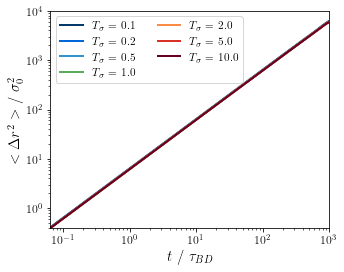


For density = 0.2


C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  from ipykernel import kernelapp as app


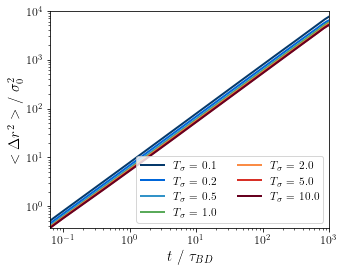


For density = 0.6


C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  from ipykernel import kernelapp as app


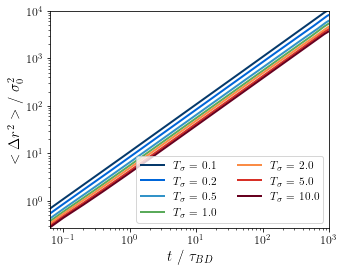


For density = 0.95


C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  from ipykernel import kernelapp as app


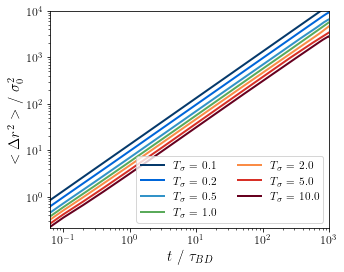


For density = 1.3


C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  from ipykernel import kernelapp as app


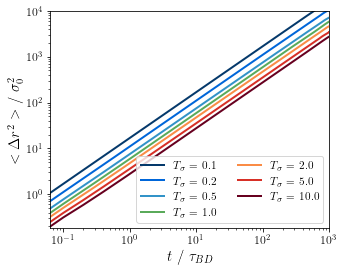


For density = 1.7


C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  from ipykernel import kernelapp as app


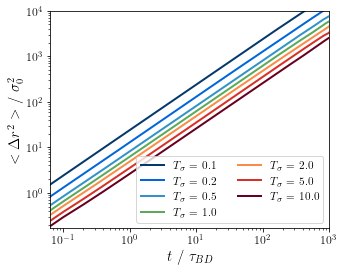


For density = 2.0


C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  from ipykernel import kernelapp as app


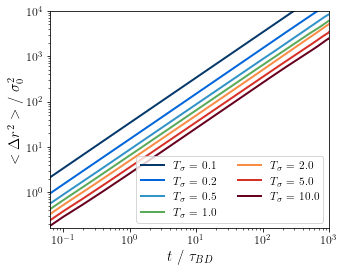

In [ ]:
D1 = np.zeros((np.size(density), np.size(lambd)))
D_err1 = np.zeros((np.size(density), np.size(lambd)))

for i in range (np.size(density)):
    D1[i], D_err1[i] = MSD_plot1(density[i], lambd)


For density = 0.02


C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  from ipykernel import kernelapp as app


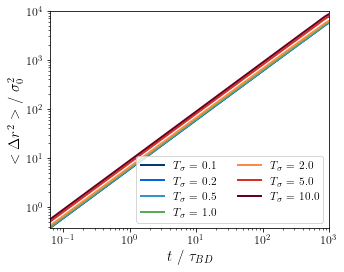


For density = 0.2


C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  from ipykernel import kernelapp as app


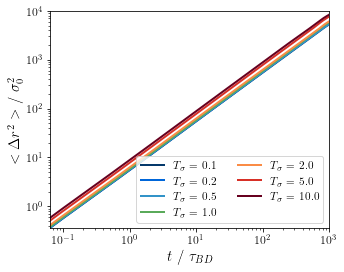


For density = 0.6


C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  from ipykernel import kernelapp as app


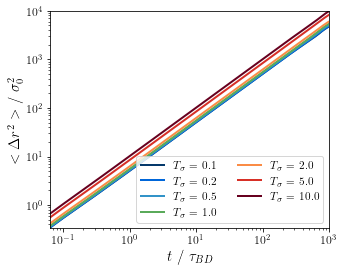


For density = 0.95


C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  from ipykernel import kernelapp as app


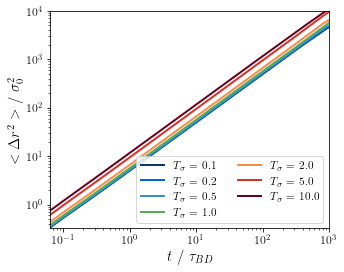


For density = 1.3


C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  from ipykernel import kernelapp as app


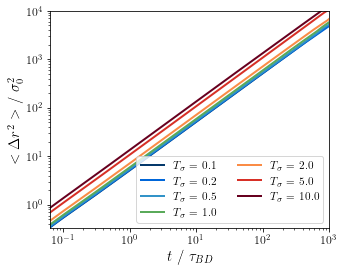


For density = 1.7


C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  from ipykernel import kernelapp as app


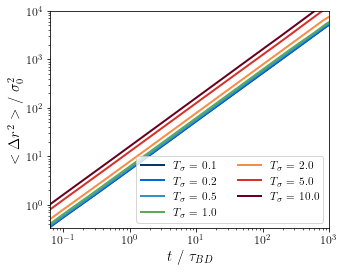


For density = 2.0


C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
C:\Users\a7722\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  from ipykernel import kernelapp as app


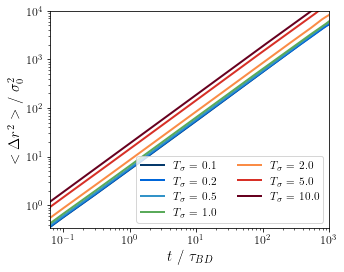

In [44]:
D2 = np.zeros((np.size(density), np.size(lambd)))
D_err2 = np.zeros((np.size(density), np.size(lambd)))

for i in range (np.size(density)):
    D2[i], D_err2[i] = MSD_plot2(density[i])

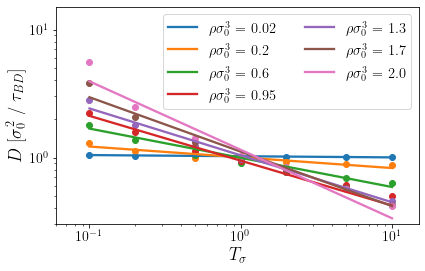

In [45]:
k = np.zeros(np.size(density)) # angle coefficient for function D(T_sigma)
k_err = np.zeros(np.size(density))
lin_appr = np.zeros((np.size(density), np.size(lambd)))
lin_appr_err = np.zeros((np.size(density), np.size(lambd)))

plt.figure(figsize=(6.5, 4))
for i in range (np.size(density)):
    plt.scatter(lambd, D1[i])
    #plt.plot(lambd, D[i], linewidth=2.5, label=r'$\rho \sigma_0^3$ = {0}'.format(density[i]))
    k[i], k_err[i], lin_appr[i, :], lin_appr_err[i, :] = fit_D(D1[i], D_err1[i], lambd)
    plt.plot(lambd, lin_appr[i, :], linewidth=2.3, label=r'$\rho \sigma_0^3$ = {0}'.format(density[i]))

plt.legend(ncol=2, fontsize=14.5)
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$D$ [$\sigma_0^2$ / $\tau_{BD}$]', fontsize=18)
plt.xlabel('$T_\sigma$', fontsize=18)
plt.xlim(0.06, 15)
plt.ylim(0.3, 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('sim1_D.pdf', bbox_inches='tight')
plt.show()

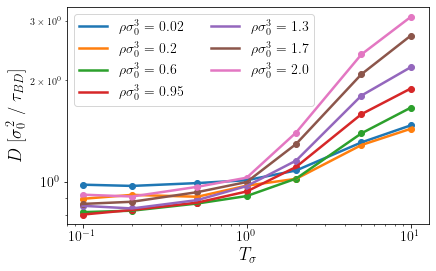

In [46]:
plt.figure(figsize=(6.5, 4))
for i in range (np.size(density)):
    plt.scatter(lambd, D2[i])
    plt.plot(lambd, D2[i], linewidth=2.5, label=r'$\rho \sigma_0^3$ = {0}'.format(density[i]))

plt.legend(ncol=2, fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$D$ [$\sigma_0^2$ / $\tau_{BD}$]', fontsize=18)
plt.xlabel('$T_\sigma$', fontsize=18)
plt.xlim(0.08, 13)
#plt.ylim(0.4, 4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('sim2_D.pdf', bbox_inches='tight')
plt.show()

In [47]:
mean_sigm1, mean_D1, lambd_th1 = N_sigma_analysis2(0.02, 1) # entropic
mean_sigm2, mean_D2, lambd_th2 = N_sigma_analysis2(0.02, 2) # energetic


For density = 0.02

For density = 0.02


In [48]:
black = (0, 0, 0)

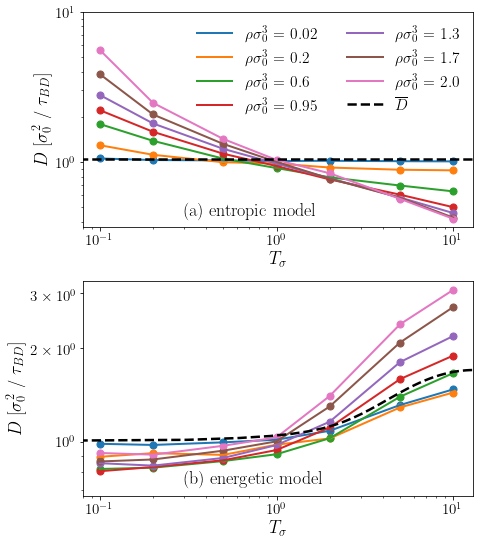

In [49]:
fig, axs = plt.subplots(2, 1, figsize=(7, 8.9))
fig.subplots_adjust(hspace=0.25)
for i in range (np.size(lambd)):    
    axs[0].scatter(lambd, D1[i], s=50)
    axs[0].plot(lambd,  D1[i], linewidth=2, label=r'$\rho \sigma_0^3$ = {0}'.format(density[i]))
    #axs[0].plot(lambd, lin_appr[i, :], linewidth=2.3, label=r'$\rho \sigma_0^3$ = {0}'.format(density[i]))    
    
    axs[1].scatter(lambd, D2[i], s=50)
    axs[1].plot(lambd, D2[i], linewidth=2, label=r'$\rho \sigma_0^3$ = {0}'.format(density[i]))
    
axs[0].plot(lambd_th1,  mean_D1, linestyle='dashed', linewidth=2.5, color=black, label=r'$\overline D$')
axs[1].plot(lambd_th2,  mean_D2, linestyle='dashed', linewidth=2.5, color=black, label=r'$\overline D$')
    
for j in range (2):
    axs[j].set_xlabel('$T_\sigma$', fontsize=18)
    axs[j].set_ylabel(r'$D$ [$\sigma_0^2$ / $\tau_{BD}$]', fontsize=18)
    
    axs[j].set_xscale('log')
    axs[j].set_yscale('log')
    axs[j].tick_params(labelsize=15)

axs[0].legend(ncol=2, fontsize=15.5, framealpha=0, handlelength=2.3)
axs[1].set_yticks([1, 2, 3])
    
axs[0].set_xlim(0.08, 13)
axs[0].set_ylim(0.37, 10)

axs[1].set_xlim(0.08, 13)
axs[1].set_ylim(0.67, 3.3)

axs[0].text(0.3, 0.44, r'(a) entropic model', fontsize=18)
axs[1].text(0.3, 0.73, r'(b) energetic model', fontsize=18)

plt.savefig('sim12_D.pdf', bbox_inches='tight')
plt.show()

In [50]:
colors2 = np.zeros((np.size(density), 3))
colors2[0, :] = (31, 119, 180)
colors2[1, :] = (255, 127, 14)
colors2[2, :] = (44, 160, 44)
colors2[3, :] = (214, 39, 40)
colors2[4, :] = (148, 103, 189)
colors2[5, :] = (140, 86, 75)
colors2[6, :] = (227, 119, 194)

colors2 = colors2 / 255

In [51]:
mean_D1_ent = np.zeros((np.size(density), np.size(lambd)))
mean_D2_ent = np.zeros((np.size(density), np.size(lambd)))
mean_D2_ener = np.zeros((np.size(density), np.size(lambd)))
mean_D1_ener = np.zeros((np.size(density), np.size(lambd)))
mean_sigma_ent = np.zeros((np.size(density), np.size(lambd)))
mean_sigma_ener = np.zeros((np.size(density), np.size(lambd)))
for i in range (np.size(density)):
    mean_D1_ent[i], mean_D2_ent[i], mean_sigma_ent[i] = mean_Ds_review(density[i], 1)
    mean_D1_ener[i], mean_D2_ener[i], mean_sigma_ener[i] = mean_Ds_review(density[i], 2)


For density = 0.02

For density = 0.02

For density = 0.2

For density = 0.2

For density = 0.6

For density = 0.6

For density = 0.95

For density = 0.95

For density = 1.3

For density = 1.3

For density = 1.7

For density = 1.7

For density = 2.0

For density = 2.0


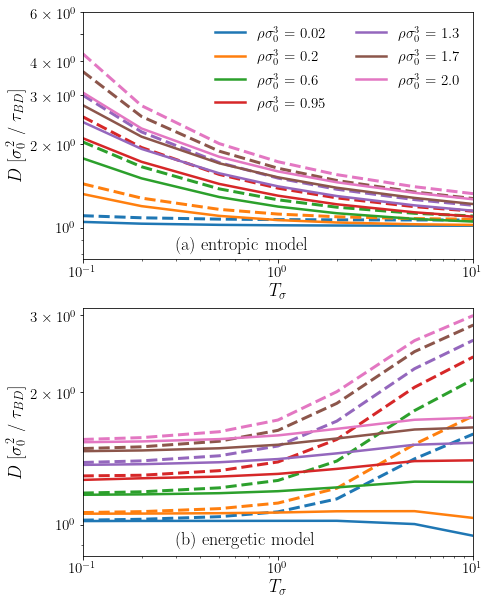

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(7, 10))
fig.subplots_adjust(hspace=0.2)
for i in range (np.size(lambd)):    
    
    axs[0].plot(lambd,  mean_D1_ent[i], color=colors2[i], linestyle='dashed', linewidth=3)
    axs[1].plot(lambd,  mean_D1_ener[i], color=colors2[i], linestyle='dashed', linewidth=3)

    axs[0].plot(lambd,  mean_D2_ent[i], linestyle='solid', linewidth=2.5, color=colors2[i], label=r'$\rho \sigma_0^3$ = {0}'.format(density[i]))
    axs[1].plot(lambd,  mean_D2_ener[i], linestyle='solid', linewidth=2.5, color=colors2[i], label=r'$\rho \sigma_0^3$ = {0}'.format(density[i]))
    
for j in range (2):
    axs[j].set_xlabel('$T_\sigma$', fontsize=18)
    axs[j].set_ylabel(r'$D$ [$\sigma_0^2$ / $\tau_{BD}$]', fontsize=18)
    
    axs[j].set_xscale('log')
    axs[j].set_yscale('log')
    axs[j].tick_params(labelsize=15)

axs[0].legend(ncol=2, fontsize=15, framealpha=0, handlelength=2.0)
axs[1].set_yticks([1, 2, 3])
axs[0].set_yticks([1, 2, 3, 4, 5, 6])
    
axs[0].set_xlim(0.1, 10)
axs[0].set_ylim(0.77, 6)

axs[1].set_xlim(0.1, 10)
axs[1].set_ylim(0.85, 3.1)

axs[0].text(0.3, 0.83, r'(a) entropic model', fontsize=18)
axs[1].text(0.3, 0.9, r'(b) energetic model', fontsize=18)

plt.savefig('sim12_Dmean.pdf', bbox_inches='tight')
plt.show()

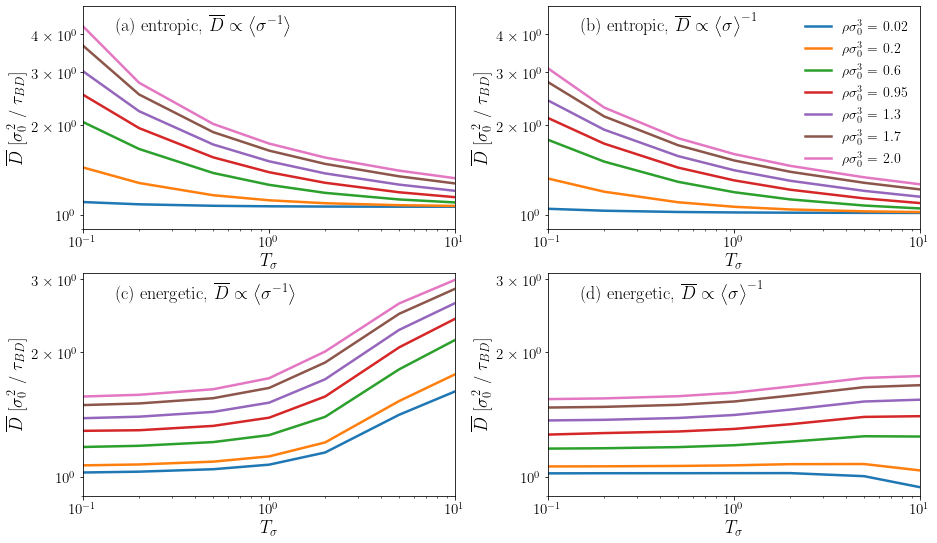

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(15, 9))
fig.subplots_adjust(hspace=0.2, wspace=0.25)

for i in range (np.size(lambd)):    
    axs[0, 0].plot(lambd,  mean_D1_ent[i], color=colors2[i], linestyle='solid', linewidth=2.5, label=r'$\rho \sigma_0^3$ = {0}'.format(density[i]))
    axs[1, 0].plot(lambd,  mean_D1_ener[i], color=colors2[i], linestyle='solid', linewidth=2.5)

    axs[0, 1].plot(lambd,  mean_D2_ent[i], linestyle='solid', linewidth=2.5, color=colors2[i], label=r'$\rho \sigma_0^3$ = {0}'.format(density[i]))
    axs[1, 1].plot(lambd,  mean_D2_ener[i], linestyle='solid', linewidth=2.5, color=colors2[i], label=r'$\rho \sigma_0^3$ = {0}'.format(density[i]))

for k in range (2):
    for j in range (2):
        axs[j, k].set_xlabel('$T_\sigma$', fontsize=18)
        axs[j, k].set_ylabel(r'$\overline{D}$ [$\sigma_0^2$ / $\tau_{BD}$]', fontsize=18)
        axs[j, k].set_xscale('log')
        axs[j, k].set_yscale('log')
        axs[j, k].tick_params(labelsize=15)
        
    axs[1, k].set_yticks([1, 2, 3])
    axs[0, k].set_yticks([1, 2, 3, 4, 5, 6])
    axs[0, k].set_xlim(0.1, 10)
    axs[0, k].set_ylim(0.9, 4.95)
    axs[1, k].set_xlim(0.1, 10)
    axs[1, k].set_ylim(0.9, 3.1)

axs[0, 1].legend(ncol=1, fontsize=14.1, framealpha=0, handlelength=1.8)
axs[0, 0].text(0.15, 4.12, r'(a) entropic, $\overline{D} \propto \big\langle \sigma^{-1} \big\rangle$', fontsize=18)
axs[1, 0].text(0.15, 2.7, r'(c) energetic, $\overline{D} \propto \big\langle \sigma^{-1} \big\rangle$', fontsize=18)
axs[0, 1].text(0.15, 4.12, r'(b) entropic, $\overline{D} \propto \big\langle \sigma \big\rangle ^{-1}$', fontsize=18)
axs[1, 1].text(0.15, 2.7, r'(d) energetic, $\overline{D} \propto \big\langle \sigma \big\rangle ^{-1}$', fontsize=18)
    
plt.savefig('sim12_Dmean.pdf', bbox_inches='tight')
plt.show()

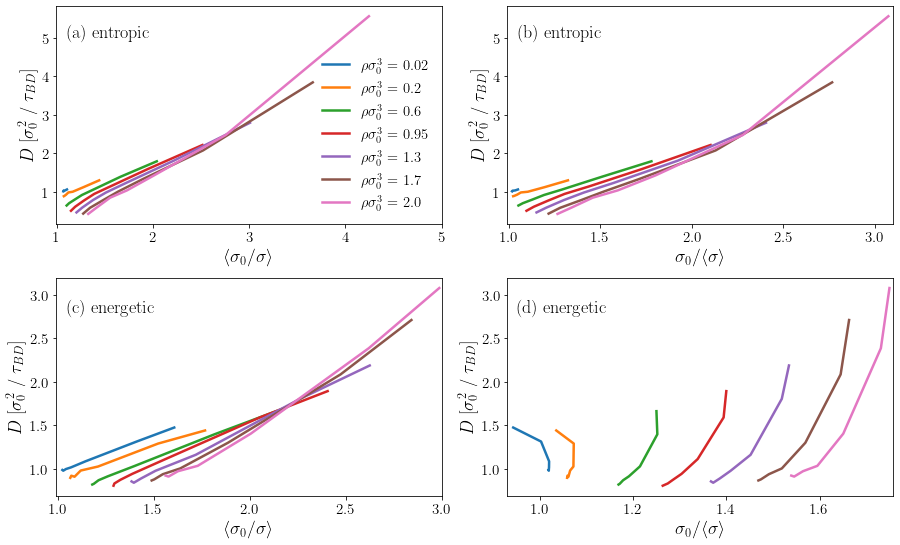

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 9))
fig.subplots_adjust(hspace=0.25, wspace=0.17)

for i in range (np.size(lambd)):    
    axs[0, 0].plot(mean_D1_ent[i], D1[i], color=colors2[i], linestyle='solid', linewidth=2.5, label=r'$\rho \sigma_0^3$ = {0}'.format(density[i]))
    axs[1, 0].plot(mean_D1_ener[i], D2[i], color=colors2[i], linestyle='solid', linewidth=2.5)

    axs[0, 1].plot(mean_D2_ent[i], D1[i], linestyle='solid', linewidth=2.5, color=colors2[i], label=r'$\rho \sigma_0^3$ = {0}'.format(density[i]))
    axs[1, 1].plot(mean_D2_ener[i], D2[i], linestyle='solid', linewidth=2.5, color=colors2[i], label=r'$\rho \sigma_0^3$ = {0}'.format(density[i]))

for k in range (2):
    axs[k, 1].set_xlabel(r'$\sigma_0 / \langle \sigma \rangle $', fontsize=18)
    axs[k, 0].set_xlabel(r'$\langle \sigma_0 / \sigma \rangle$', fontsize=18)
    for j in range (2):    
        axs[j, k].set_ylabel(r'$D$ [$\sigma_0^2$ / $\tau_{BD}$]', fontsize=18)
        axs[j, k].tick_params(labelsize=15)

axs[0, 0].legend(ncol=1, fontsize=14.7, framealpha=0, handlelength=1.8)
axs[0, 0].text(1.1, 5, r'(a) entropic', fontsize=18)
axs[1, 0].text(1.05, 2.8, r'(c) energetic', fontsize=18)
axs[0, 1].text(1.05, 5, r'(b) entropic', fontsize=18)
axs[1, 1].text(0.95, 2.8, r'(d) energetic', fontsize=18)
axs[0, 0].set_xlim(0.99, 5)

axs[1, 0].set_xlim(0.99, 3.0)
axs[0, 1].set_xlim(0.99, 3.1)
axs[1, 1].set_xlim(0.93, 1.757)

    
plt.savefig('sim12_D_Einstein.pdf', bbox_inches='tight')
plt.show()